## Mount google drive and define functions for data import

In [3]:

import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.measure import regionprops, label
from scipy.stats import lognorm, norm
from sklearn.metrics import r2_score
import ast

import os
import itertools

# --- Utility Functions ---
def getDirectories(basePath, flowRates, temps, angles, aeration_rates, trials):
    all_combinations = list(itertools.product(angles, temps, aeration_rates, trials, flowRates))
    all_dirs = []
    for angle, temp, aeration, trial, flow in all_combinations:
        aeration_str = str(aeration).replace('.', '_')
        flow_str = str(flow).replace('.', '_')
        rel_path = f"{angle} Degree/{temp}F/{aeration_str} Percent Trial {trial}/{flow_str}"
        full_path = os.path.join(basePath, rel_path)
        if os.path.exists(full_path):
            all_dirs.append((full_path, angle, temp, aeration, trial, flow))
    return all_dirs

def parse_mat_struct(mat_struct):
    return {name: mat_struct[name][0, 0] if mat_struct[name].ndim == 2 else mat_struct[name]
            for name in mat_struct.dtype.names}

def safe_get_scalar(d, key):
    try:
        return float(np.squeeze(d[key]))
    except Exception:
        return np.nan

from google.colab import drive
drive.mount('/content/drive')


basePath = "/content/drive/MyDrive/Master's Data Processing/Thesis Data/"
flowRates = [1.5, 2.5, 3.5, 4.5, 5.5]
temps = [120, 180, 225]
angles = [7, 15, 30]
aeration_rates = [0.2]
trials = [1, 2]

dirs = getDirectories(basePath, flowRates, temps, angles, aeration_rates, trials)
experiment_folder = dirs[5]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Import Data

In [3]:
UM_PER_PIXEL = 5.77
from scipy.io import loadmat

# --- Process ---
records = []
for full_path, angle, temp, aer, trial, flow in dirs:
    record = {
        'Temp': temp,
        'FlowRate': flow,
        'VenturiAngle': angle,
        'AeratedFlow': aer,
        'Trial': trial,
        'Valid': True
    }

    # Read LabVIEW CSV
    labview_path = os.path.join(full_path, 'labview.txt')
    if os.path.isfile(labview_path):
        try:
            data = pd.read_csv(labview_path, encoding='utf-8', on_bad_lines='skip')
            record['MeanTemp'] = data['Temp (F)'].mean()
            record['MeanFlow'] = data['Oil Flow Rate'].mean()
            record['MeanP1'] = data['P1'].mean()
            record['MeanP2'] = data['P2'].mean()
            record['StdTemp'] = data['Temp (F)'].std()
            record['StdFlow'] = data['Oil Flow Rate'].std()
            record['StdP1'] = data['P1'].std()
            record['StdP2'] = data['P2'].std()
        except Exception as e:
            print(f"Error reading {labview_path}: {e}")
    else:
        print(f"Missing LabVIEW file: {labview_path}")

    # Read MATLAB Results
    mat_path = os.path.join(full_path, 'MATLAB Results', 'lognormal_fit_params2.mat')
    if os.path.isfile(mat_path):
        try:
            mat = loadmat(mat_path)
            if 'tempLogData' in mat:
                raw = mat['tempLogData']
                if isinstance(raw, np.ndarray) and raw.dtype.names:
                    logdata = parse_mat_struct(raw[0, 0])
                    record['LogMu'] = safe_get_scalar(logdata, 'mu')
                    record['LogSigma'] = safe_get_scalar(logdata, 'sigma')
                    record['D32'] = safe_get_scalar(logdata, 'SauterMeanDiameter')
                    record['D_v'] = safe_get_scalar(logdata, 'D_v')
                    record['MedianDiameter'] = safe_get_scalar(logdata, 'MedianDiameter') if 'MedianDiameter' in logdata else np.nan
        except Exception as e:
            print(f"Error reading {mat_path}: {e}")
    else:
        print(f"Missing .mat file: {mat_path}")

    # Read SAM Results
    sam_path = os.path.join(full_path, 'experiment_summary.csv')
    if os.path.isfile(sam_path):
        try:
            sam_df = pd.read_csv(sam_path)
            if 'log_mu' in sam_df:
                log_mu_pixels = sam_df['log_mu'].iloc[0]
                record['LogMu_sam'] = log_mu_pixels + np.log(UM_PER_PIXEL)
            else:
                record['LogMu_sam'] = np.nan
            record['LogSigma_sam'] = sam_df['log_sigma'].iloc[0] if 'log_sigma' in sam_df else np.nan
            record['D32_sam'] = sam_df['d32'].iloc[0] * UM_PER_PIXEL if 'd32' in sam_df else np.nan
            record['D_v_sam'] = sam_df['dv'].iloc[0] * UM_PER_PIXEL if 'dv' in sam_df else np.nan
        except Exception as e:
            print(f"Error reading {sam_path}: {e}")
    else:
        print(f"Missing SAM summary file: {sam_path}")

    records.append(record)

# --- Create DataFrame ---
df = pd.DataFrame.from_records(records)


# --- Post Processing ---
df['deltaP'] = df['MeanP1'] - df['MeanP2']
df['deltaP_Pa'] = df['deltaP'] * 6894.75729

tempF = df['MeanTemp'].combine_first(df['Temp'])
df['tempK'] = (tempF - 32) / 1.8 + 273.15

# Fluid properties
A, B = 732, -3.803
alpha, rho_ref = 0.000994, 959
T_ref = 298.15
df['mu'] = 10 ** (A / df['tempK'] + B)
df['rho'] = rho_ref * (1 - alpha * (df['tempK'] - T_ref))
df['nu'] = df['mu'] / df['rho']

# Velocity and Reynolds number
D_t = 6e-3
A_throat = np.pi * D_t ** 2 / 4
GPM_to_m3_s = 1 / (264.172053 * 60)
flow = df['MeanFlow'].combine_first(df['FlowRate'])
df['V_throat'] = flow * GPM_to_m3_s / A_throat
df['Reynolds'] = df['V_throat'] * D_t / df['nu']

# Dynamic pressure and normalized pressure drop
df['dynamicPressure'] = 0.5 * df['rho'] * df['V_throat'] ** 2
df['deltaP_normalized'] = df['deltaP_Pa'] / df['dynamicPressure']

# Capillary and Weber numbers
df['Gamma'] = (22.3 - 0.06 * (df['tempK'] - 273.15)) / 1000
df['Ca'] = df['mu'] * df['V_throat'] / df['Gamma']
df['We_D'] = df['rho'] * df['V_throat'] ** 2 * D_t / df['Gamma']
D_p = 15.8e-3
df['L'] = (D_p - D_t) / np.tan(np.radians(df['VenturiAngle']))
df['We_L'] = df['rho'] * df['V_throat'] ** 2 * df['L'] / df['Gamma']

# --- Output ---
with pd.option_context('display.max_columns', None, 'display.width', None):
    print(df.head(5))


Error reading /content/drive/MyDrive/Master's Data Processing/Thesis Data/7 Degree/120F/0_2 Percent Trial 2/1_5/labview.txt: No columns to parse from file
Error reading /content/drive/MyDrive/Master's Data Processing/Thesis Data/7 Degree/180F/0_2 Percent Trial 2/1_5/labview.txt: Could not convert string '178.607311178.560128178.575856178.595515178.720550178.796044178.809525178.754758178.775073178.791326178.819636178.890413178.937598178.942317178.928161178.862102178.791326178.814918178.796044178.781889178.772452178.701676178.678085178.640338178.569565178.569565178.602592178.593156178.607311178.597874178.588438178.612029178.612029178.640338178.659212178.678085178.663930178.640338178.593156178.574283178.579001178.541255178.541255178.508228178.512946178.508228178.522383178.527101178.536537178.616747178.616747178.663930178.654493178.706395178.701676178.753578178.786607178.796044178.819636178.715832178.701676178.659212178.621465178.583719178.602592178.541255178.517665178.574283178.616747178.

## Filter Data for Plotting

In [7]:
import numpy as np
import pandas as pd

# --- Filter Parameters ---
plotAngles = [7, 15, 30]
plotTemps = [120, 180, 225]
plotAerations = [0.2]
minimumRe = 0
plotExternal = False  # Not used yet

# --- Filtering (preserves original df) ---
df_filtered = df[
    df['VenturiAngle'].isin(plotAngles) &
    df['Temp'].isin(plotTemps) &
    df['AeratedFlow'].isin(plotAerations) &
    (df['Reynolds'] > minimumRe)
].copy()

# --- Plotting Styles ---
# You can update these to match your color/style preferences
colors = [
    "#D8AB4C", "#4cd866", "#d84cbe",  # For Temp
    "#000000", "#664cd8", "#4cbed8"   # For Angles
]

# Marker map for angles
angleMarkerMap = {
    7: '^',    # Triangle
    15: 'o',   # Circle
    30: 's'    # Square
}

# Color map for temperatures
tempColorMap = {
    120: colors[0],
    180: colors[1],
    225: colors[2]
}

# Color map for angles
angleColorMap = {
    7: colors[3],
    15: colors[4],
    30: colors[5]
}


## Plot repeatability and SAM-MATLAB comparison

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps

def plot_repeatability(df, plot_orig=True, plot_sam=False):
    # Define variable names from your dataset
    var_labels = [r'$\mu_{LN}$', r'$\sigma_{LN}$', r'$d_{32}$', r'$d_{30}$']
    matlab_cols = ['LogMu', 'LogSigma', 'D32', 'D_v']
    sam_cols = ['LogMu_sam', 'LogSigma_sam', 'D32_sam', 'D_v_sam']

    # Identify unique experimental conditions (excluding trial number)
    param_cols = ['Temp', 'FlowRate', 'VenturiAngle', 'AeratedFlow']
    df['param_id'] = df[param_cols].apply(tuple, axis=1)
    unique_params = df['param_id'].unique()

    def extract_trials(df, use_sam=False):
        t1_data, t2_data = [], []
        cols = sam_cols if use_sam else matlab_cols

        for param in unique_params:
            subset = df[df['param_id'] == param]
            trial1 = subset[subset['Trial'] == 1]
            trial2 = subset[subset['Trial'] == 2]
            if len(trial1) == 1 and len(trial2) == 1:
                try:
                    t1_data.append([trial1[cols[i]].values[0] for i in range(4)])
                    t2_data.append([trial2[cols[i]].values[0] for i in range(4)])
                except KeyError as e:
                    print(f"Missing column: {e}")
        return np.array(t1_data), np.array(t2_data)

    trial1_orig, trial2_orig = extract_trials(df, use_sam=False)
    trial1_sam, trial2_sam = extract_trials(df, use_sam=True)

    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.flatten()

    for i in range(4):
        ax = axes[i]

        x_all, y_all = [], []

        if plot_orig and trial1_orig.size > 0:
            x_orig, y_orig = trial1_orig[:, i], trial2_orig[:, i]
            ax.scatter(x_orig, y_orig, s=50, label='MATLAB', alpha=0.7)
            x_all.append(x_orig)
            y_all.append(y_orig)

        if plot_sam and trial1_sam.size > 0:
            x_sam, y_sam = trial1_sam[:, i], trial2_sam[:, i]
            ax.scatter(x_sam, y_sam, s=50, marker='x', label='SAM', alpha=0.7)
            x_all.append(x_sam)
            y_all.append(y_sam)

        # Axis limits and diagonal
        if x_all and y_all:
            all_x = np.concatenate(x_all)
            all_y = np.concatenate(y_all)
            min_val, max_val = min(all_x.min(), all_y.min()), max(all_x.max(), all_y.max())
            margin = 0.05 * (max_val - min_val)
            ax.plot([min_val - margin, max_val + margin],
                    [min_val - margin, max_val + margin], 'k--')
            ax.set_xlim([min_val - margin, max_val + margin])
            ax.set_ylim([min_val - margin, max_val + margin])

        ax.set_xlabel(f'Trial 1 {var_labels[i]}', fontsize=12)
        ax.set_ylabel(f'Trial 2 {var_labels[i]}', fontsize=12)
        ax.set_title(f'{var_labels[i]} Repeatability', fontsize=13)
        ax.grid(True)

        if plot_orig and trial1_orig.size > 0:
            r2 = np.corrcoef(trial1_orig[:, i], trial2_orig[:, i])[0, 1]**2
            ax.text(0.02, 0.95, f'MATLAB $R^2$ = {r2:.3f}', transform=ax.transAxes, fontsize=9, verticalalignment='top')

        if plot_sam and trial1_sam.size > 0:
            r2 = np.corrcoef(trial1_sam[:, i], trial2_sam[:, i])[0, 1]**2
            ax.text(0.02, 0.85, f'SAM $R^2$ = {r2:.3f}', transform=ax.transAxes, fontsize=9, verticalalignment='top')

        if plot_orig and plot_sam:
            ax.legend()

    fig.suptitle('Repeatability Analysis: Trial 2 vs Trial 1', fontsize=14)
    plt.tight_layout()
    plt.show()

def plot_sam_vs_matlab(df):
    import matplotlib.pyplot as plt
    import numpy as np

    # Define the variable mappings
    matlab_cols = ['LogMu', 'LogSigma', 'D32', 'D_v']
    sam_cols = ['LogMu_sam', 'LogSigma_sam', 'D32_sam', 'D_v_sam']
    var_labels = [r'$\mu_{LN}$', r'$\sigma_{LN}$', r'$d_{32}$', r'$d_{30}$']

    # Identify unique experimental conditions (excluding trial number)
    param_cols = ['Temp', 'FlowRate', 'VenturiAngle', 'AeratedFlow']
    df['param_id'] = df[param_cols].apply(tuple, axis=1)
    unique_params = df['param_id'].unique()

    sam_data = []
    matlab_data = []

    for param in unique_params:
        subset = df[df['param_id'] == param]
        trials = subset['Trial'].values

        if set(trials) == {1, 2}:
            try:
                sam_avg = subset[sam_cols].mean().values
                matlab_avg = subset[matlab_cols].mean().values
                sam_data.append(sam_avg)
                matlab_data.append(matlab_avg)
            except KeyError as e:
                print(f"Missing column for param {param}: {e}")

    sam_data = np.array(sam_data)
    matlab_data = np.array(matlab_data)

    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.flatten()

    for i in range(4):
        ax = axes[i]
        x = matlab_data[:, i]
        y = sam_data[:, i]

        ax.scatter(x, y, s=50, alpha=0.8)
        min_val, max_val = min(x.min(), y.min()), max(x.max(), y.max())
        margin = 0.05 * (max_val - min_val)
        min_val -= margin
        max_val += margin

        ax.plot([min_val, max_val], [min_val, max_val], 'k--')
        ax.set_xlim([min_val, max_val])
        ax.set_ylim([min_val, max_val])

        ax.set_xlabel(f'MATLAB Avg {var_labels[i]}', fontsize=12)
        ax.set_ylabel(f'SAM Avg {var_labels[i]}', fontsize=12)
        ax.set_title(f'SAM vs MATLAB: {var_labels[i]}', fontsize=13)
        ax.grid(True)

        r_squared = np.corrcoef(x, y)[0, 1]**2
        ax.text(min_val + 0.05*(max_val - min_val), max_val - 0.1*(max_val - min_val),
                f'$R^2$ = {r_squared:.3f}', fontsize=10)

    fig.suptitle('Comparison: SAM vs MATLAB (Averaged Across Trials)', fontsize=14)
    plt.tight_layout()
    plt.show()



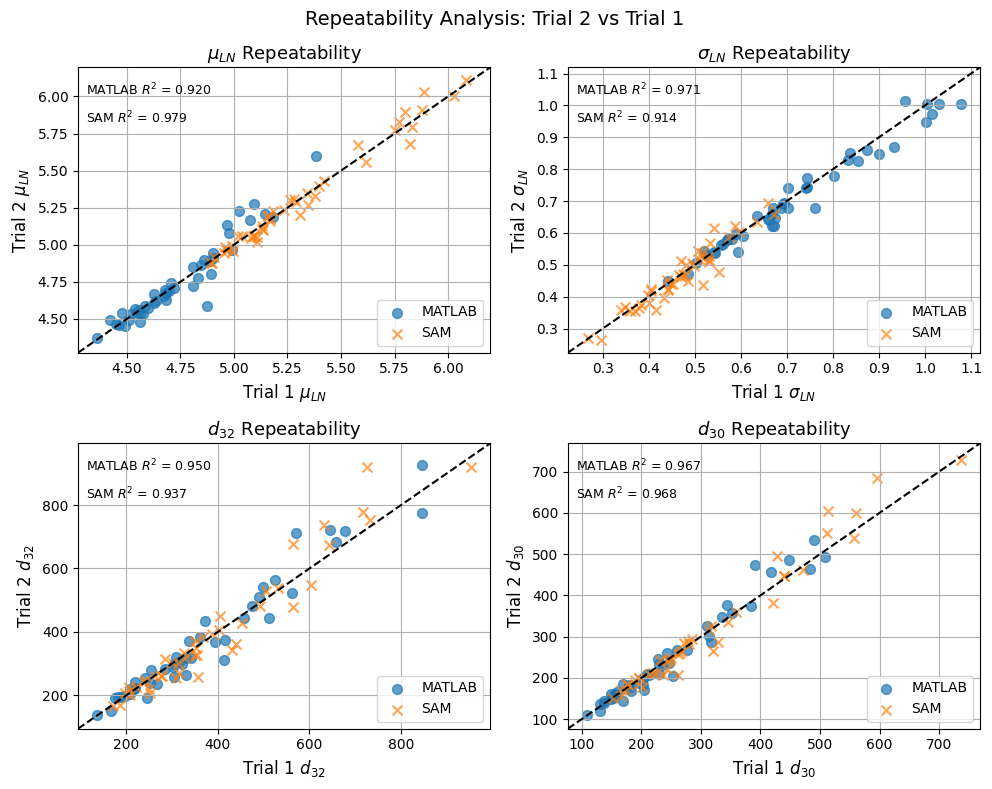

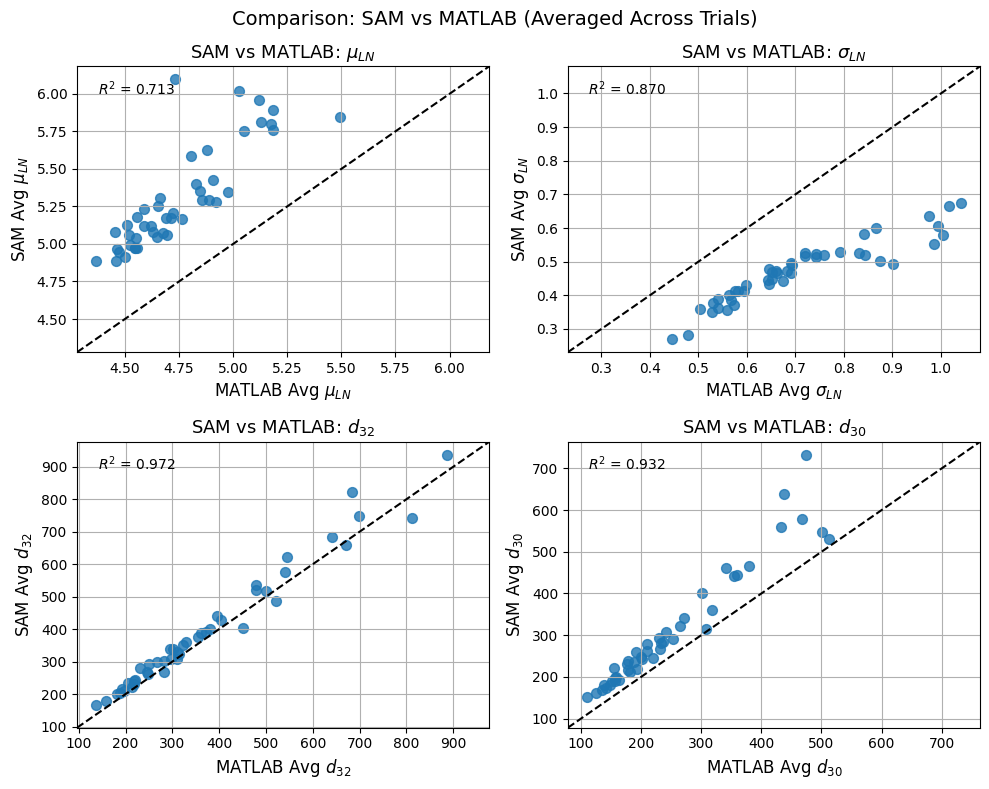

In [56]:
#plot_repeatability(df_filtered, plot_orig=True, plot_sam=False)
plot_repeatability(df_filtered, plot_orig=True, plot_sam=True)

plot_sam_vs_matlab(df_filtered)

In [ ]:
## Flow Rate Plots

In [42]:
def plot_flow_rate_effect(df, angle, aeration, plot_orig=True, plot_sam=False):
    import matplotlib.pyplot as plt
    import numpy as np

    filtered = df[(df['VenturiAngle'] == angle) & (df['AeratedFlow'] == aeration)]
    if filtered.empty:
        raise ValueError('No data found for specified parameters.')

    avg_df = filtered.groupby(['Temp', 'FlowRate'], as_index=False).mean(numeric_only=True)
    temps = sorted(avg_df['Temp'].unique())
    color_map = plt.cm.get_cmap('tab10', len(temps))

    # --- Define plot configuration ---
    variable_map = {
        'd30': ('D_v', 'D_v_sam', r'$\mathrm{d}_{30}$', r'Volume-Equivalent Diameter ($\mu m$)', (0, 1100)),
        'sigma': ('LogSigma', 'LogSigma_sam', r'$\sigma_{LN}$', r'Log-Normal $\sigma_{LN}$', (0, 2))
    }

    sources = []
    if plot_orig:
        sources.append(('MATLAB', 'D_v', 'LogSigma'))
    if plot_sam:
        sources.append(('SAM', 'D_v_sam', 'LogSigma_sam'))

    ncols = len(sources)
    nrows = 2  # d30 and sigma rows

    fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 5 * nrows))
    if ncols == 1:
        axes = np.array(axes).reshape((2, 1))  # force 2D array for consistency

    for row_idx, (key, (col_orig, col_sam, title, ylabel, ylim)) in enumerate(variable_map.items()):
        for col_idx, (label, d_col, sigma_col) in enumerate(sources):
            ax = axes[row_idx, col_idx]
            col_name = col_orig if label == 'MATLAB' else col_sam

            for j, temp in enumerate(temps):
                subset = avg_df[avg_df['Temp'] == temp].sort_values(by='FlowRate')
                ax.plot(subset['FlowRate'], subset[col_name], '-o',
                        label=f'{temp}°F', color=color_map(j), markerfacecolor=color_map(j))

            ax.set_xlabel('Flow Rate (GPM)')
            ax.set_ylabel(ylabel)
            ax.set_title(f'{title} vs Flow Rate ({label})')
            ax.grid(True)
            ax.set_xlim([0, 6])
            ax.set_ylim(ylim)

            if col_name == 'D_v':
                ax.axhline(1000, linestyle='--', color='k', label='Injection Hole Diameter')

            if row_idx == 0:
                ax.legend()

    plt.tight_layout()
    plt.show()



def plot_flow_rate_analysis(df, angle, temperature, aeration_percent, colors, plot_orig=True, plot_sam=False):
    filtered = df[(df['VenturiAngle'] == angle) & (df['Temp'] == temperature) &
                  (df['AeratedFlow'] == aeration_percent)]
    if filtered.empty:
        raise ValueError('No data found for specified parameters.')

    avg_df = filtered.groupby('FlowRate', as_index=False).mean(numeric_only=True).sort_values('FlowRate')

    x = np.linspace(0, 1200, 1000)
    fig, ax1 = plt.subplots(figsize=(10, 6))

    if plot_orig:
        for i, row in avg_df.iterrows():
            mu, sigma = row['LogMu'], row['LogSigma']
            pdf_vals = lognorm.pdf(x, s=sigma, scale=np.exp(mu))
            color = colors[i % len(colors)]
            ax1.plot(x, pdf_vals, label=f"{row['FlowRate']} GPM (MATLAB)", color=color, linewidth=2)
            if not np.isnan(row['D_v']):
                ax1.axvline(row['D_v'], linestyle='--', color=color, linewidth=1.5)

    if plot_sam:
        for i, row in avg_df.iterrows():
            mu, sigma = row['LogMu_sam'], row['LogSigma_sam']
            pdf_vals = lognorm.pdf(x, s=sigma, scale=np.exp(mu))
            color = colors[i % len(colors)]
            ax1.plot(x, pdf_vals, linestyle=':', label=f"{row['FlowRate']} GPM (SAM)", color=color, linewidth=2)
            if not np.isnan(row['D_v_sam']):
                ax1.axvline(row['D_v_sam'], linestyle=':', color=color, linewidth=1.5)

    ax1.set_xlabel(r'Diameter ($\mu m$)', fontsize=14)
    ax1.set_ylabel('Probability Density', fontsize=14)
    ax1.set_title(f'Log-Normal Distributions for {angle}° Venturi, {temperature}°F, {aeration_percent}% Aeration', fontsize=16)
    ax1.grid(True)
    ax1.set_xlim([0, 1200])
    ax1.legend()
    plt.tight_layout()
    plt.show()

    # Plot 2: D_v vs Flow Rate
    plt.figure(figsize=(8, 5))
    if plot_orig:
        plt.plot(avg_df['FlowRate'], avg_df['D_v'], '-o', color=colors[0], label=r'$\mathrm{d}_{30}$ (MATLAB)', linewidth=2)
    if plot_sam:
        plt.plot(avg_df['FlowRate'], avg_df['D_v_sam'], '--x', color=colors[1], label=r'$\mathrm{d}_{30}$ (SAM)', linewidth=2)

    plt.xlabel('Flow Rate (GPM)', fontsize=14)
    plt.ylabel(r'Diameter ($\mu m$)', fontsize=14)
    plt.title(f'Volume-Equivalent Diameter vs Flow Rate for {angle}°, {temperature}°F, {aeration_percent}% Aeration', fontsize=15)
    plt.grid(True)
    plt.ylim([0, max(avg_df[['D_v', 'D_v_sam']].max(skipna=True)) * 1.5])
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot 3: LogMu and LogSigma vs Flow Rate
    plt.figure(figsize=(8, 5))
    if plot_orig:
        plt.plot(avg_df['FlowRate'], avg_df['LogMu'], '-d', label=r'$\mu_{LN}$ (MATLAB)', color=colors[2], linewidth=2)
        plt.plot(avg_df['FlowRate'], avg_df['LogSigma'], '-^', label=r'$\sigma_{LN}$ (MATLAB)', color=colors[3], linewidth=2)
    if plot_sam:
        plt.plot(avg_df['FlowRate'], avg_df['LogMu_sam'], '--d', label=r'$\mu_{LN}$ (SAM)', color=colors[4], linewidth=2)
        plt.plot(avg_df['FlowRate'], avg_df['LogSigma_sam'], '--^', label=r'$\sigma_{LN}$ (SAM)', color=colors[5], linewidth=2)

    plt.xlabel('Flow Rate (GPM)', fontsize=14)
    plt.ylabel('Log-Normal Parameters', fontsize=14)
    plt.title(f'Log-Normal Parameters vs Flow Rate for {angle}°, {temperature}°F, {aeration_percent}% Aeration',
              fontsize=15)
    plt.grid(True)
    plt.legend()
    plt.xlim([0, 6])
    all_mu = pd.concat([avg_df[['LogMu']] if plot_orig else [],
                        avg_df[['LogMu_sam']] if plot_sam else []], axis=1)
    plt.ylim([0, all_mu.max().max() * 1.2])
    plt.tight_layout()
    plt.show()


<ipython-input-42-1296758752>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab10', len(temps))


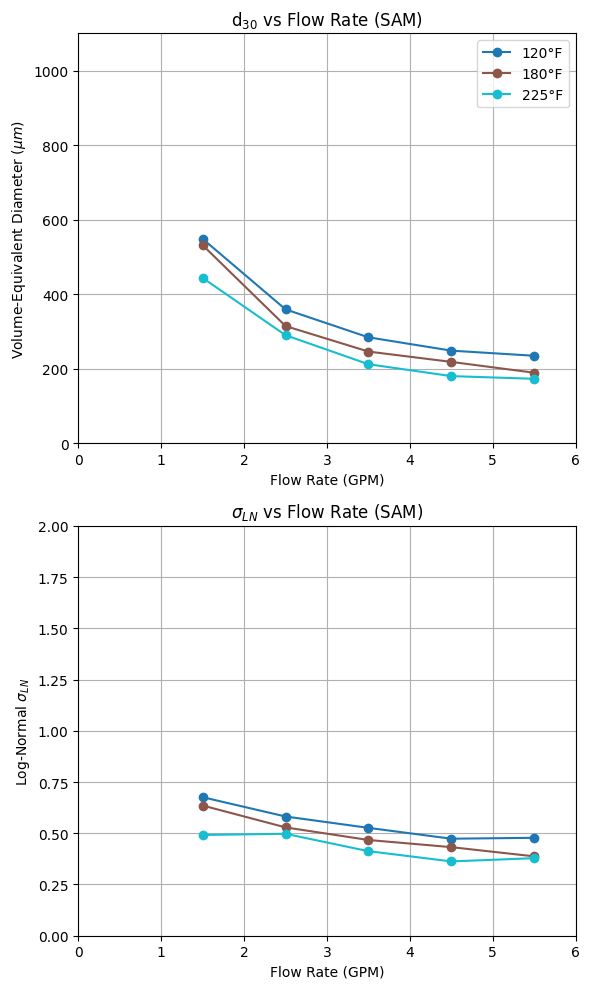

In [43]:
plot_flow_rate_effect(df_filtered, angle=7, aeration=0.2, plot_orig=False, plot_sam=True)

# colors = ['#D8AB4C', '#4cd866', '#d84cbe', '#000000', '#664cd8', '#4cbed8']
# plot_flow_rate_analysis(df_filtered, angle=15, temperature=180, aeration_percent=0.2,
#                         colors=colors, plot_orig=True, plot_sam=True)


## Temperature Plots

In [53]:
def plot_temperature_effect(df, angle, aeration, plot_orig=True, plot_sam=False):
    import matplotlib.pyplot as plt
    import numpy as np

    filtered = df[(df['VenturiAngle'] == angle) & (df['AeratedFlow'] == aeration)]
    if filtered.empty:
        raise ValueError('No data found for specified parameters.')

    avg_df = filtered.groupby(['Temp', 'FlowRate'], as_index=False).mean(numeric_only=True)
    flow_rates = sorted(avg_df['FlowRate'].unique())
    color_map = plt.cm.get_cmap('Dark2', len(flow_rates))

    # --- Define plot configuration ---
    variable_map = {
        'd30': ('D_v', 'D_v_sam', r'$\mathrm{d}_{30}$', r'Volume-Equivalent Diameter ($\mu m$)', (0, 1100)),
        'sigma': ('LogSigma', 'LogSigma_sam', r'$\sigma_{LN}$', r'Log-Normal $\sigma_{LN}$', (0, 2))
    }

    sources = []
    if plot_orig:
        sources.append(('MATLAB', 'D_v', 'LogSigma'))
    if plot_sam:
        sources.append(('SAM', 'D_v_sam', 'LogSigma_sam'))

    ncols = len(sources)
    nrows = 2  # d30 and sigma

    fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 5 * nrows))
    if ncols == 1:
        axes = np.array(axes).reshape((2, 1))  # ensure it's 2D (2 rows, 1 column)

    for row_idx, (key, (col_orig, col_sam, title, ylabel, ylim)) in enumerate(variable_map.items()):
        for col_idx, (label, d_col, sigma_col) in enumerate(sources):
            ax = axes[row_idx, col_idx]
            col_name = col_orig if label == 'MATLAB' else col_sam

            for j, flow in enumerate(flow_rates):
                subset = avg_df[avg_df['FlowRate'] == flow].sort_values(by='Temp')
                ax.plot(subset['Temp'], subset[col_name], '-o',
                        label=f'{flow:.1f} GPM', color=color_map(j), markerfacecolor=color_map(j))

            ax.set_xlabel('Temperature (°F)')
            ax.set_ylabel(ylabel)
            ax.set_title(f'{title} vs Temperature ({label})')
            ax.grid(True)
            ax.set_ylim(ylim)
            ax.set_xlim([avg_df['Temp'].min() - 5, avg_df['Temp'].max() + 5])

            if 'D_v' in col_name:
                ax.axhline(1000, linestyle='--', color='k', label='Injection Hole Diameter')

            if row_idx == 0:
                ax.legend()

    plt.tight_layout()
    plt.show()




def plot_temperature_analysis(df, angle, flow_rate, aeration_percent, colors, plot_orig=True, plot_sam=False):
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy.stats import lognorm

    filtered = df[(df['VenturiAngle'] == angle) &
                  (df['FlowRate'] == flow_rate) &
                  (df['AeratedFlow'] == aeration_percent)]
    if filtered.empty:
        raise ValueError('No data found for specified parameters.')

    avg_df = filtered.groupby('Temp', as_index=False).mean(numeric_only=True).sort_values('Temp')
    x = np.linspace(0, 1200, 1000)

    # Plot 1: Log-normal PDF
    fig, ax = plt.subplots(figsize=(10, 6))

    if plot_orig:
        for i, row in avg_df.iterrows():
            mu, sigma = row['LogMu'], row['LogSigma']
            pdf_vals = lognorm.pdf(x, s=sigma, scale=np.exp(mu))
            color = colors[i % len(colors)]
            ax.plot(x, pdf_vals, label=f"{row['Temp']}°F (MATLAB)", color=color, linewidth=2)
            if not np.isnan(row['D_v']):
                ax.axvline(row['D_v'], linestyle='--', color=color, linewidth=1.5)

    if plot_sam:
        for i, row in avg_df.iterrows():
            mu, sigma = row['LogMu_sam'], row['LogSigma_sam']
            pdf_vals = lognorm.pdf(x, s=sigma, scale=np.exp(mu))
            color = colors[i % len(colors)]
            ax.plot(x, pdf_vals, linestyle=':', label=f"{row['Temp']}°F (SAM)", color=color, linewidth=2)
            if not np.isnan(row['D_v_sam']):
                ax.axvline(row['D_v_sam'], linestyle=':', color=color, linewidth=1.5)

    ax.set_xlabel(r'Diameter ($\mu m$)', fontsize=14)
    ax.set_ylabel('Probability Density', fontsize=14)
    ax.set_title(f'Log-Normal Distributions for {angle}°, {flow_rate} GPM, {aeration_percent}% Aeration', fontsize=16)
    ax.grid(True)
    ax.set_xlim([0, 1200])
    ax.legend()
    plt.tight_layout()
    plt.show()

    # Plot 2: D_v vs Temp
    plt.figure(figsize=(8, 5))
    if plot_orig:
        plt.plot(avg_df['Temp'], avg_df['D_v'], '-o', color=colors[0], label=r'$\mathrm{d}_{30}$ (MATLAB)', linewidth=2)
    if plot_sam:
        plt.plot(avg_df['Temp'], avg_df['D_v_sam'], '--x', color=colors[1], label=r'$\mathrm{d}_{30}$ (SAM)', linewidth=2)

    plt.xlabel('Temperature (°F)', fontsize=14)
    plt.ylabel(r'Diameter ($\mu m$)', fontsize=14)
    plt.title(f'Volume-Equivalent Diameter vs Temperature for {angle}°, {flow_rate} GPM, {aeration_percent}%', fontsize=15)
    plt.grid(True)
    plt.ylim([0, max(avg_df[['D_v', 'D_v_sam']].max(skipna=True)) * 1.5])
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot 3: LogMu and LogSigma vs Temp
    plt.figure(figsize=(8, 5))
    if plot_orig:
        plt.plot(avg_df['Temp'], avg_df['LogMu'], '-d', label=r'$\mu_{LN}$ (MATLAB)', color=colors[2], linewidth=2)
        plt.plot(avg_df['Temp'], avg_df['LogSigma'], '-^', label=r'$\sigma_{LN}$ (MATLAB)', color=colors[3], linewidth=2)
    if plot_sam:
        plt.plot(avg_df['Temp'], avg_df['LogMu_sam'], '--d', label=r'$\mu_{LN}$ (SAM)', color=colors[4], linewidth=2)
        plt.plot(avg_df['Temp'], avg_df['LogSigma_sam'], '--^', label=r'$\sigma_{LN}$ (SAM)', color=colors[5], linewidth=2)

    plt.xlabel('Temperature (°F)', fontsize=14)
    plt.ylabel('Log-Normal Parameters', fontsize=14)
    plt.title(f'Log-Normal Parameters vs Temperature for {angle}°, {flow_rate} GPM, {aeration_percent}%', fontsize=15)
    plt.grid(True)
    plt.legend()
    plt.xlim([min(avg_df['Temp']), max(avg_df['Temp'])])
    all_mu = pd.concat([avg_df[['LogMu']] if plot_orig else [],
                        avg_df[['LogMu_sam']] if plot_sam else []], axis=1)
    plt.ylim([0, all_mu.max().max() * 1.2])
    plt.tight_layout()
    plt.show()


<ipython-input-53-4035867520>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('Dark2', len(flow_rates))


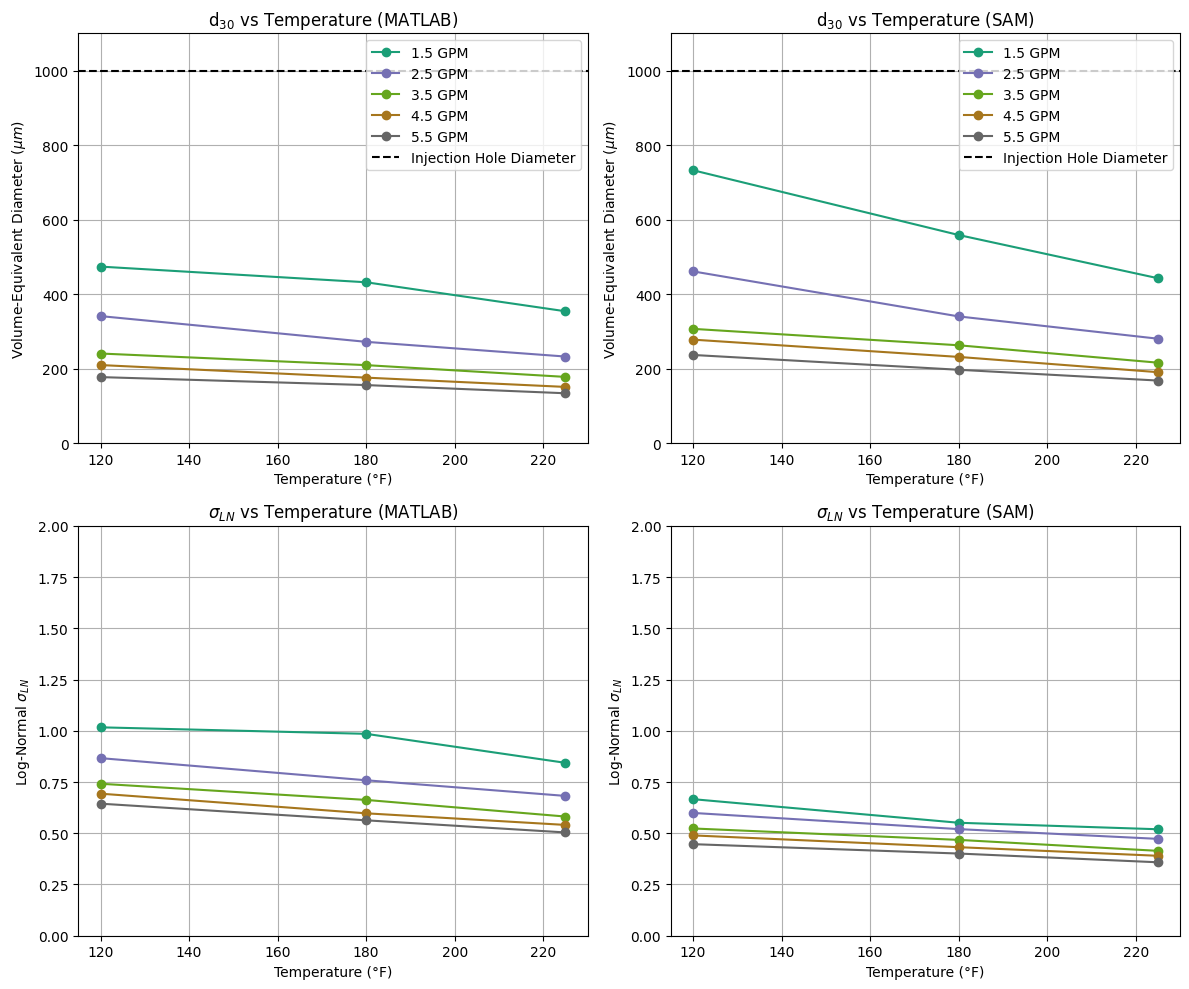

In [55]:
# Side-by-side variable comparison across temperature, series = flow rates
plot_temperature_effect(df_filtered, angle=30, aeration=0.2, plot_orig=True, plot_sam=True)

# Temperature analysis for a single flow rate
# colors = ['#D8AB4C', '#4cd866', '#d84cbe', '#000000', '#664cd8', '#4cbed8']
# plot_temperature_analysis(df_filtered, angle=15, flow_rate=3.5, aeration_percent=0.2,
#                           colors=colors, plot_orig=True, plot_sam=True)


## Angle Plots

In [51]:
def plot_angle_effect(df, flow_rate, aeration, plot_orig=True, plot_sam=False):
    import matplotlib.pyplot as plt
    import numpy as np

    filtered = df[(df['FlowRate'] == flow_rate) & (df['AeratedFlow'] == aeration)]
    if filtered.empty:
        raise ValueError('No data found for specified parameters.')

    avg_df = filtered.groupby(['VenturiAngle', 'Temp'], as_index=False).mean(numeric_only=True)
    temps = sorted(avg_df['Temp'].unique())
    color_map = plt.cm.get_cmap('Set2', len(temps))

    variable_map = {
        'd30': ('D_v', 'D_v_sam', r'$\mathrm{d}_{30}$', r'Volume-Equivalent Diameter ($\mu m$)', (0, 1100)),
        'sigma': ('LogSigma', 'LogSigma_sam', r'$\sigma_{LN}$', r'Log-Normal $\sigma_{LN}$', (0, 2))
    }

    sources = []
    if plot_orig:
        sources.append(('MATLAB', 'D_v', 'LogSigma'))
    if plot_sam:
        sources.append(('SAM', 'D_v_sam', 'LogSigma_sam'))

    ncols = len(sources)
    nrows = 2

    fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 5 * nrows))
    if ncols == 1:
        axes = np.array(axes).reshape((2, 1))

    for row_idx, (key, (col_orig, col_sam, title, ylabel, ylim)) in enumerate(variable_map.items()):
        for col_idx, (label, d_col, sigma_col) in enumerate(sources):
            ax = axes[row_idx, col_idx]
            col_name = col_orig if label == 'MATLAB' else col_sam

            for j, temp in enumerate(temps):
                subset = avg_df[avg_df['Temp'] == temp].sort_values(by='VenturiAngle')
                ax.plot(subset['VenturiAngle'], subset[col_name], '-o',
                        label=f'{temp}°F', color=color_map(j), markerfacecolor=color_map(j))

            ax.set_xlabel('Venturi Angle (deg)')
            ax.set_ylabel(ylabel)
            ax.set_title(f'{title} vs Angle ({label})')
            ax.grid(True)
            ax.set_ylim(ylim)
            ax.set_xlim([avg_df['VenturiAngle'].min() - 2, avg_df['VenturiAngle'].max() + 2])

            if 'D_v' in col_name:
                ax.axhline(1000, linestyle='--', color='k', label='Injection Hole Diameter')

            if row_idx == 0:
                ax.legend()

    plt.tight_layout()
    plt.show()

def plot_angle_analysis(df, temperature, flow_rate, aeration_percent, colors, plot_orig=True, plot_sam=False):
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy.stats import lognorm

    filtered = df[(df['Temp'] == temperature) &
                  (df['FlowRate'] == flow_rate) &
                  (df['AeratedFlow'] == aeration_percent)]
    if filtered.empty:
        raise ValueError('No data found for specified parameters.')

    avg_df = filtered.groupby('VenturiAngle', as_index=False).mean(numeric_only=True).sort_values('VenturiAngle')
    x = np.linspace(0, 1200, 1000)

    # Plot 1: Log-normal PDF
    fig, ax = plt.subplots(figsize=(10, 6))
    if plot_orig:
        for i, row in avg_df.iterrows():
            mu, sigma = row['LogMu'], row['LogSigma']
            pdf_vals = lognorm.pdf(x, s=sigma, scale=np.exp(mu))
            color = colors[i % len(colors)]
            ax.plot(x, pdf_vals, label=f"{row['VenturiAngle']}° (MATLAB)", color=color, linewidth=2)
            if not np.isnan(row['D_v']):
                ax.axvline(row['D_v'], linestyle='--', color=color, linewidth=1.5)

    if plot_sam:
        for i, row in avg_df.iterrows():
            mu, sigma = row['LogMu_sam'], row['LogSigma_sam']
            pdf_vals = lognorm.pdf(x, s=sigma, scale=np.exp(mu))
            color = colors[i % len(colors)]
            ax.plot(x, pdf_vals, linestyle=':', label=f"{row['VenturiAngle']}° (SAM)", color=color, linewidth=2)
            if not np.isnan(row['D_v_sam']):
                ax.axvline(row['D_v_sam'], linestyle=':', color=color, linewidth=1.5)

    ax.set_xlabel(r'Diameter ($\mu m$)', fontsize=14)
    ax.set_ylabel('Probability Density', fontsize=14)
    ax.set_title(f'Log-Normal Distributions vs Angle ({temperature}°F, {flow_rate} GPM, {aeration_percent}%)', fontsize=16)
    ax.grid(True)
    ax.set_xlim([0, 1200])
    ax.legend()
    plt.tight_layout()
    plt.show()

    # Plot 2: D_v vs Angle
    plt.figure(figsize=(8, 5))
    if plot_orig:
        plt.plot(avg_df['VenturiAngle'], avg_df['D_v'], '-o', color=colors[0], label=r'$\mathrm{d}_{30}$ (MATLAB)', linewidth=2)
    if plot_sam:
        plt.plot(avg_df['VenturiAngle'], avg_df['D_v_sam'], '--x', color=colors[1], label=r'$\mathrm{d}_{30}$ (SAM)', linewidth=2)

    plt.xlabel('Venturi Angle (deg)', fontsize=14)
    plt.ylabel(r'Diameter ($\mu m$)', fontsize=14)
    plt.title(f'Volume-Equivalent Diameter vs Angle ({temperature}°F, {flow_rate} GPM)', fontsize=15)
    plt.grid(True)
    plt.legend()
    plt.ylim([0, max(avg_df[['D_v', 'D_v_sam']].max(skipna=True)) * 1.5])
    plt.tight_layout()
    plt.show()

    # Plot 3: LogMu and LogSigma vs Angle
    plt.figure(figsize=(8, 5))
    if plot_orig:
        plt.plot(avg_df['VenturiAngle'], avg_df['LogMu'], '-d', label=r'$\mu_{LN}$ (MATLAB)', color=colors[2], linewidth=2)
        plt.plot(avg_df['VenturiAngle'], avg_df['LogSigma'], '-^', label=r'$\sigma_{LN}$ (MATLAB)', color=colors[3], linewidth=2)
    if plot_sam:
        plt.plot(avg_df['VenturiAngle'], avg_df['LogMu_sam'], '--d', label=r'$\mu_{LN}$ (SAM)', color=colors[4], linewidth=2)
        plt.plot(avg_df['VenturiAngle'], avg_df['LogSigma_sam'], '--^', label=r'$\sigma_{LN}$ (SAM)', color=colors[5], linewidth=2)

    plt.xlabel('Venturi Angle (deg)', fontsize=14)
    plt.ylabel('Log-Normal Parameters', fontsize=14)
    plt.title(f'LogMu and Sigma vs Angle ({temperature}°F, {flow_rate} GPM)', fontsize=15)
    plt.grid(True)
    plt.legend()
    all_mu = pd.concat([avg_df[['LogMu']] if plot_orig else [],
                        avg_df[['LogMu_sam']] if plot_sam else []], axis=1)
    plt.ylim([0, all_mu.max().max() * 1.2])
    plt.tight_layout()
    plt.show()


<ipython-input-51-171743702>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('Set2', len(temps))


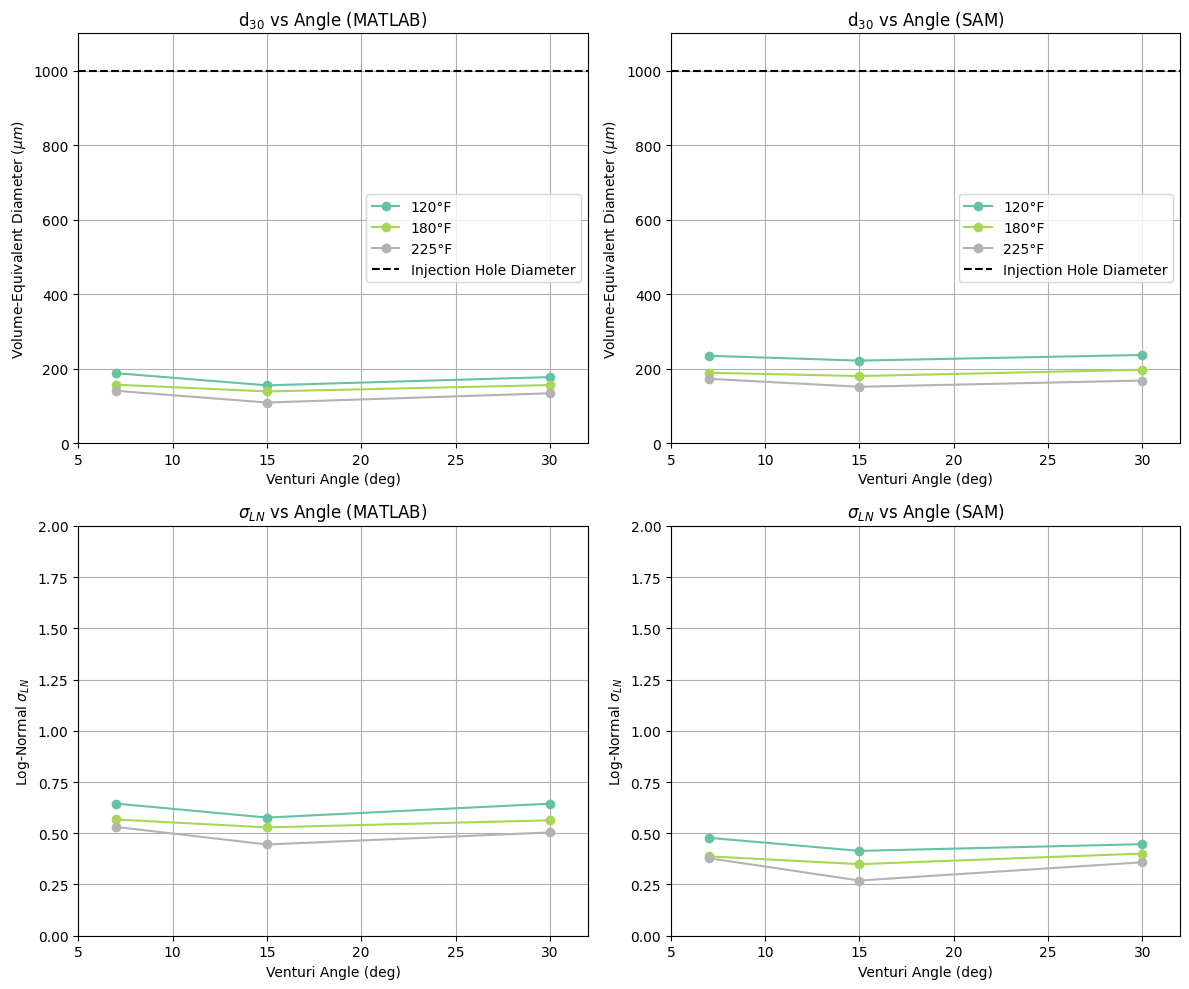

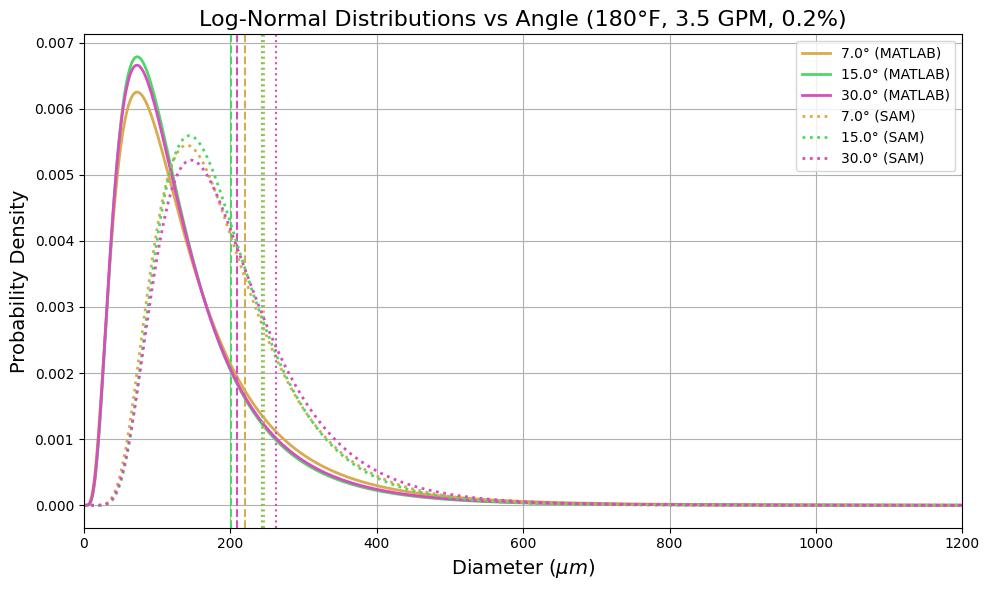

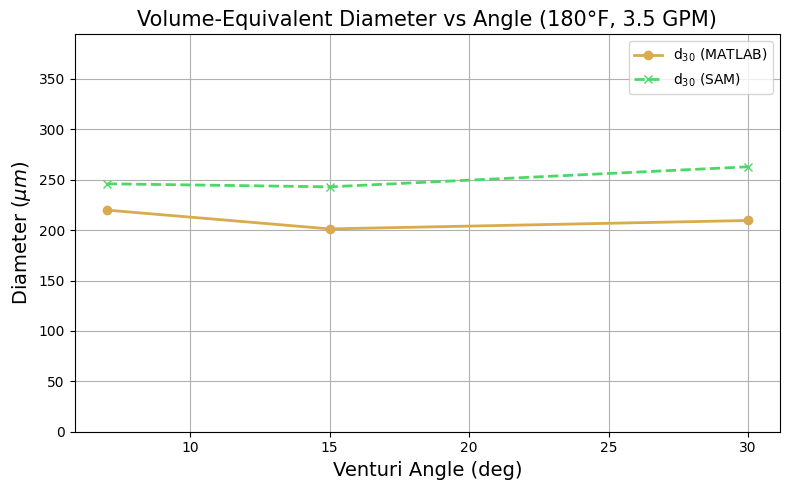

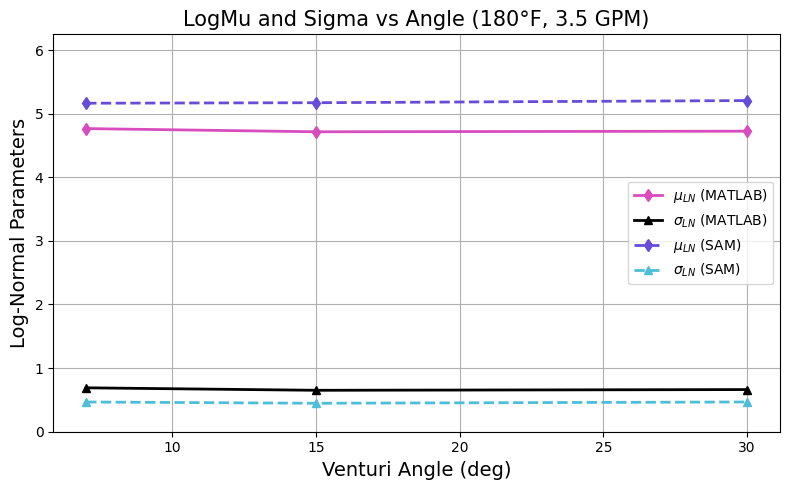

In [52]:
plot_angle_effect(df_filtered, flow_rate=5.5, aeration=0.2, plot_orig=True, plot_sam=True)

colors = ['#D8AB4C', '#4cd866', '#d84cbe', '#000000', '#664cd8', '#4cbed8']
plot_angle_analysis(df_filtered, temperature=180, flow_rate=3.5, aeration_percent=0.2,
                    colors=colors, plot_orig=True, plot_sam=True)


In [1]:


def plot_diameter_histogram_from_summary(base_dir):
    summary_path = os.path.join(base_dir, "experiment_summary.csv")
    if not os.path.exists(summary_path):
        print(f"Summary not found at {summary_path}")
        return

    df = pd.read_csv(summary_path)
    try:
        diameters = ast.literal_eval(df['diameters'].values[0])
        diameters = np.array(diameters)
    except Exception as e:
        print(f"Error reading diameters: {e}")
        return

    log_mu = df['log_mu'].values[0]
    log_sigma = df['log_sigma'].values[0]

    shape, scale = log_sigma, np.exp(log_mu)
    x = np.linspace(diameters.min(), diameters.max(), 500)
    pdf = lognorm.pdf(x, s=shape, loc=0, scale=scale)

    plt.figure(figsize=(8, 5))
    plt.hist(diameters, bins=30, density=True, alpha=0.6, color='gray', edgecolor='black', label='Observed')
    plt.plot(x, pdf, 'r-', lw=2, label=f'Lognormal Fit\nlog μ={log_mu:.2f}, log σ={log_sigma:.2f}')
    plt.xlabel("Bubble Diameter (pixels)")
    plt.ylabel("Probability Density")
    plt.title("Histogram of Bubble Diameters")
    plt.legend()
    plt.grid(True)
    plt.show()

    log_d = np.log(diameters)
    log_x = np.linspace(log_d.min(), log_d.max(), 500)
    normal_pdf = norm.pdf(log_x, loc=log_mu, scale=log_sigma)
    hist_vals, hist_bins = np.histogram(log_d, bins=30, density=True)
    hist_centers = 0.5 * (hist_bins[1:] + hist_bins[:-1])
    pred_vals = norm.pdf(hist_centers, loc=log_mu, scale=log_sigma)
    r2 = r2_score(hist_vals, pred_vals)

    plt.figure(figsize=(8, 5))
    plt.hist(log_d, bins=20, density=True, alpha=0.6, color='gray', edgecolor='black', label='Observed (log-space)')
    plt.plot(log_x, normal_pdf, 'r-', lw=2,label=f'Normal Fit in Log-space\nμ={log_mu:.2f}, σ={log_sigma:.2f}\n$R^2$={r2:.3f}')
    plt.xlabel("log(Diameter)")
    plt.ylabel("Probability Density")
    plt.title("Log-space Histogram of Bubble Diameters")
    plt.legend()
    plt.grid(True)
    plt.show()

import matplotlib.pyplot as plt
import numpy as np

def plot_detected_circles(image, properties, circularity_thresh=0.6):
    if image.ndim == 2:
        image_rgb = np.stack([image]*3, axis=-1)
    else:
        image_rgb = image.copy()

    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    axs[0].imshow(image_rgb)
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    axs[1].imshow(image_rgb)
    count = 0
    for prop in properties:
        if prop.get('circularity', 0) >= circularity_thresh:
            y, x = prop['centroid']
            r = prop['diameter'] / 2
            circle = plt.Circle((x, y), r, edgecolor='cyan', fill=False, linewidth=0.7)
            axs[1].add_patch(circle)
            axs[1].plot(x, y, 'r.', markersize=3)
            count += 1

    axs[1].set_title(f"Detected Circles (n={count}, circularity ≥ {circularity_thresh})")
    axs[1].axis('off')
    plt.tight_layout()
    plt.show()


import os
import json
import cv2

def view_frame_circles_from_json(base_dir, index):
    """
    Displays detected circles for the i-th frame in the experiment's image folder.

    Args:
        base_dir: Path to the experiment directory (e.g., .../15 Degree/225F/...Trial X/Y.Y)
        index: Integer index of the image to view
    """
    image_dir = os.path.join(base_dir, "3 - Normalized")
    if not os.path.exists(image_dir):
        print(f"Image directory not found: {image_dir}")
        return

    all_files = sorted(f for f in os.listdir(image_dir) if f.lower().endswith(".png"))
    if not all_files:
        print("No .png images found in image directory.")
        return

    if index >= len(all_files):
        print(f"Index {index} out of range (max {len(all_files) - 1})")
        return

    frame_name = all_files[index]
    img_path = os.path.join(image_dir, frame_name)
    image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

    json_path = os.path.join(base_dir, "per_frame_props.json")
    if not os.path.isfile(json_path):
        print(f"JSON file not found: {json_path}")
        return

    with open(json_path, 'r') as f:
        try:
            all_props = json.load(f)
        except json.JSONDecodeError:
            print("Error: Could not decode per_frame_props.json")
            return

    props = all_props.get(frame_name, [])
    plot_detected_circles(image, props)

    print(f"Viewing frame {index}: {frame_name}")



Angle=15, Temp=180, Flow=3.5 GPM — Viewing frame 5


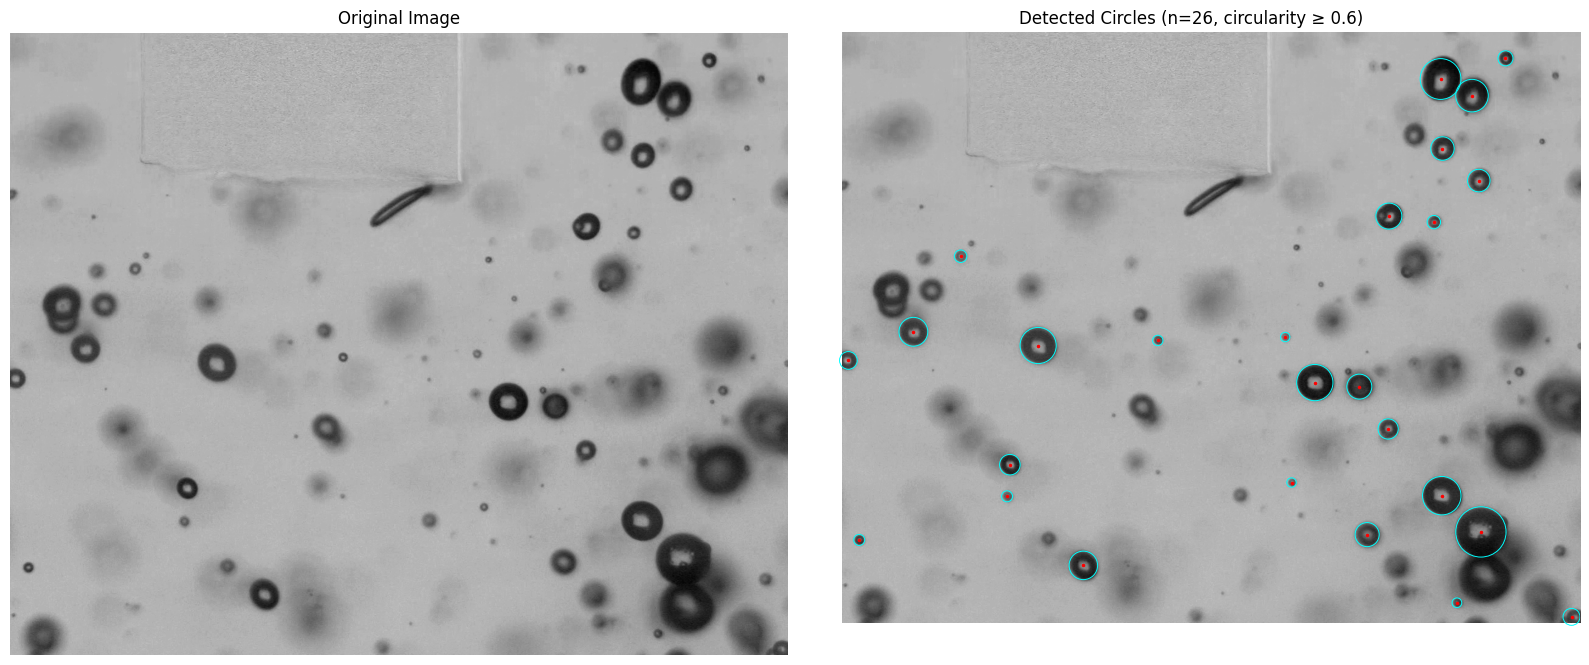

Viewing frame 0: Frame_0001.png
Angle=15, Temp=180, Flow=3.5 GPM — Viewing frame 5


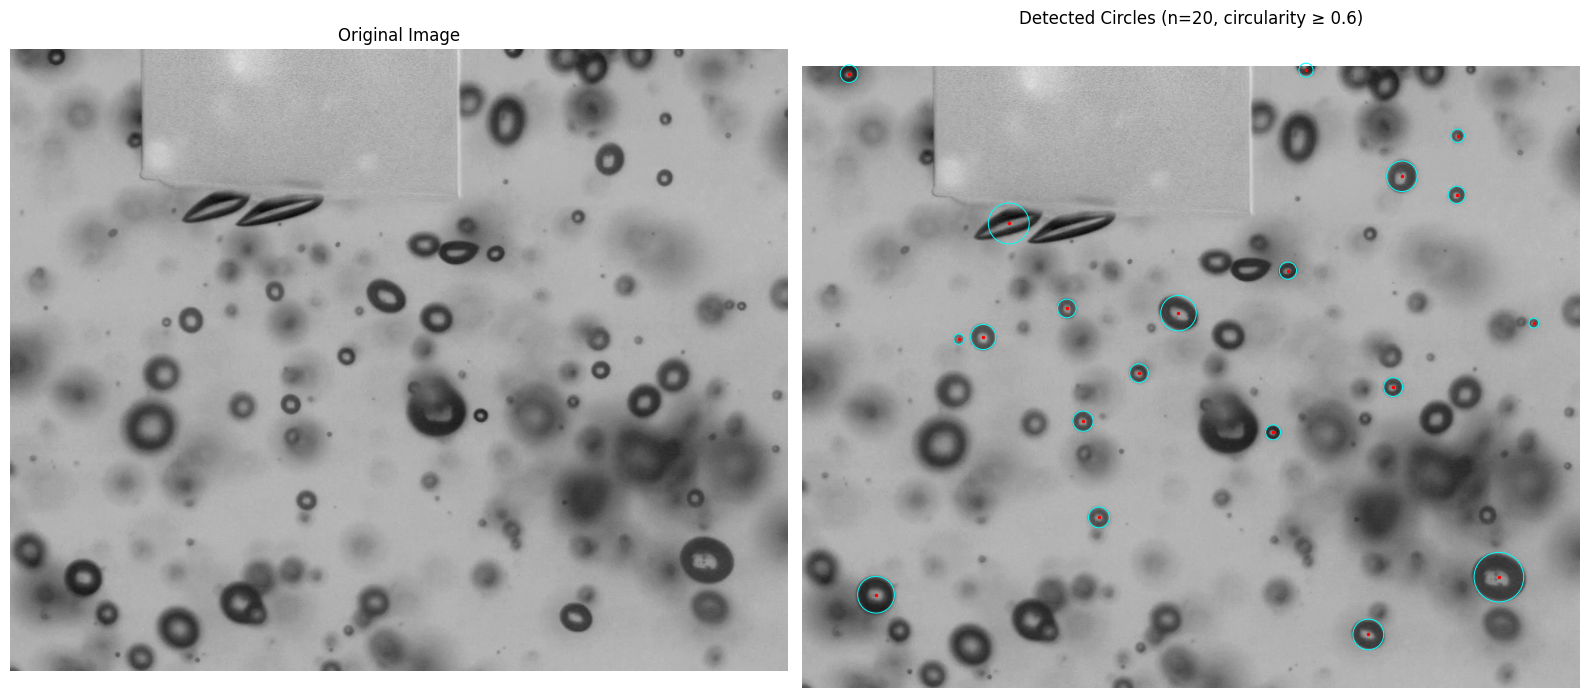

Viewing frame 1: Frame_0014.png
Angle=15, Temp=180, Flow=3.5 GPM — Viewing frame 5


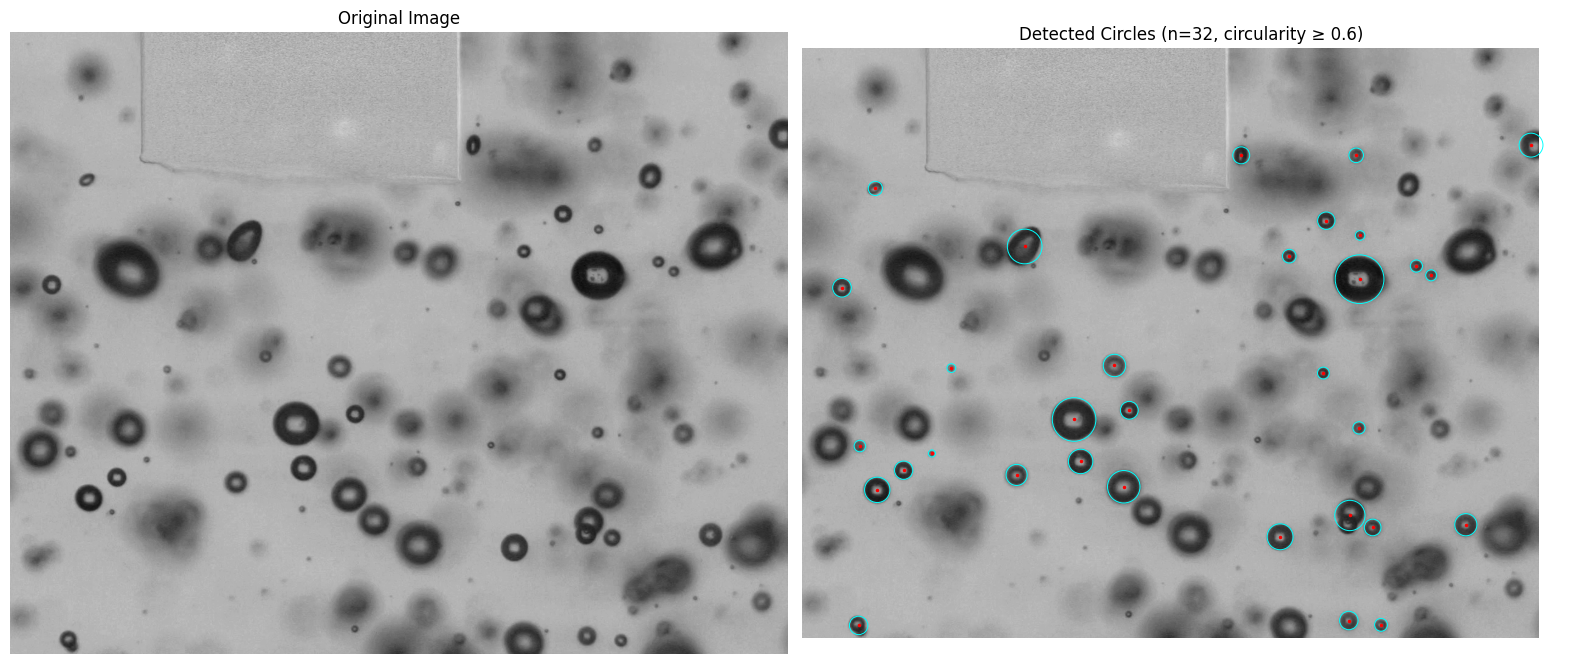

Viewing frame 2: Frame_0027.png
Angle=15, Temp=180, Flow=3.5 GPM — Viewing frame 5


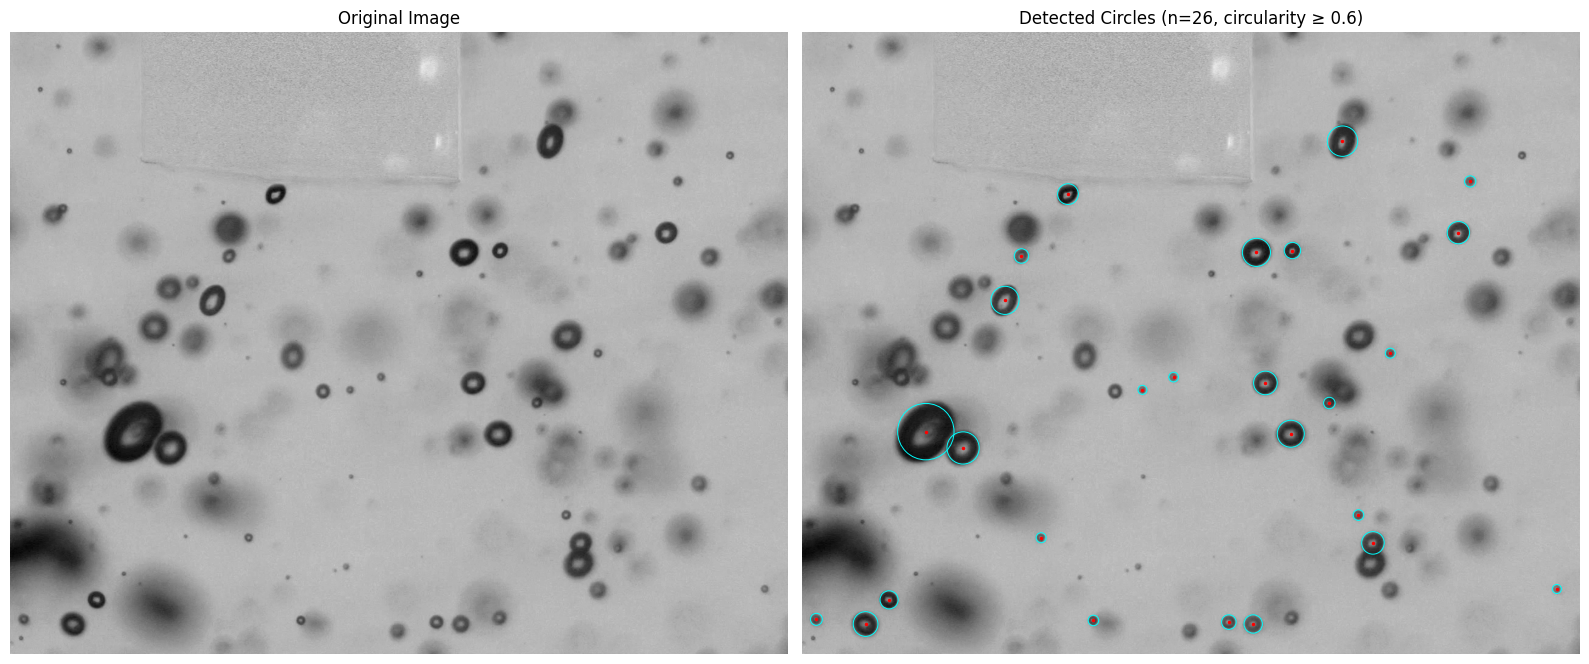

Viewing frame 3: Frame_0040.png
Angle=15, Temp=180, Flow=3.5 GPM — Viewing frame 5


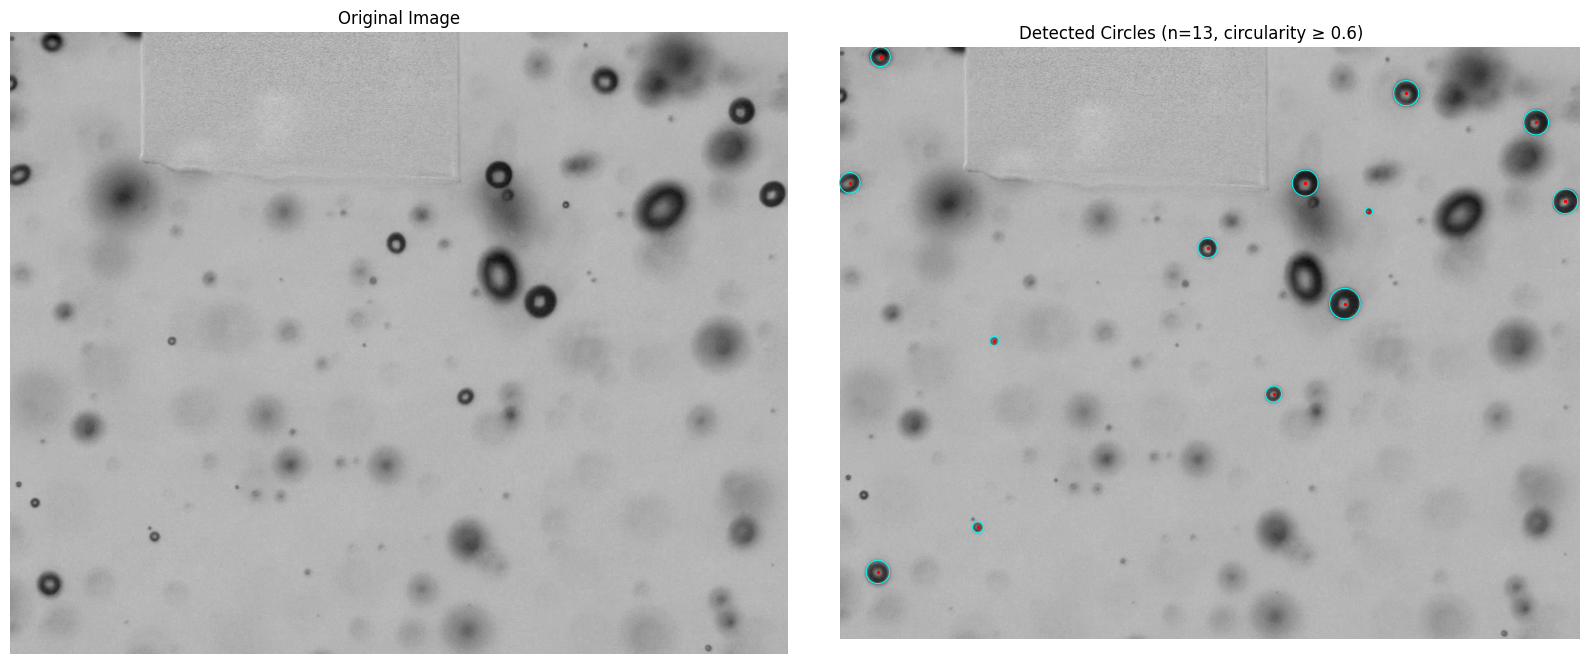

Viewing frame 4: Frame_0053.png


In [6]:
%matplotlib inline
basePath = "/content/drive/MyDrive/Master's Data Processing/Thesis Data/"
flowRates = [3.5]
temps = [180]
angles = [15]
aeration_rates = [0.2]
trials = [1]

viz_dirs = getDirectories(basePath, flowRates, temps, angles, aeration_rates, trials)

# View the 5th frame from each trial 2 dataset
for index in range(5):
  for full_path, angle, temp, aer, trial, flow in viz_dirs:
      print(f"Angle={angle}, Temp={temp}, Flow={flow} GPM — Viewing frame 5")
      view_frame_circles_from_json(full_path, index)



## Interactive Checker


2025-06-12 18:46:55.252 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-12 18:46:55.253 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-12 18:46:55.255 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-12 18:46:55.256 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-12 18:46:55.257 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-12 18:46:55.258 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-12 18:46:55.260 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-12 18:46:55.262 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()

In [11]:
!pip install streamlit pyngrok opencv-python-headless
app_code = """
# streamlit_bubble_compare.py
import streamlit as st
import os
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

# --- Utility Functions ---
def load_image(base_dir, frame_name):
    img_path = os.path.join(base_dir, "3 - Normalized", frame_name)
    image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    return image

def load_sam_props(base_dir, frame_name):
    json_path = os.path.join(base_dir, "per_frame_props.json")
    if os.path.exists(json_path):
        with open(json_path, 'r') as f:
            props = json.load(f).get(frame_name, [])
        return props
    return []

def draw_circles(image, props, color='cyan', circularity_thresh=0.6):
    fig, ax = plt.subplots()
    ax.imshow(image)
    for prop in props:
        if prop.get('circularity', 1.0) >= circularity_thresh:
            y, x = prop['centroid']
            r = prop['diameter'] / 2
            circ = Circle((x, y), r, edgecolor=color, fill=False, linewidth=0.8)
            ax.add_patch(circ)
    ax.axis('off')
    return fig

# --- Streamlit UI ---
st.set_page_config(layout="wide")
st.title("Bubble Detection Viewer: SAM Results")

base_dir = st.text_input("Base experiment directory", "/content/drive/MyDrive/Master's Data Processing/Thesis Data/15 Degree/225F/0_2 Percent Trial 1/3_5")

if not os.path.exists(base_dir):
    st.warning("Please enter a valid base directory path.")
    st.stop()

image_dir = os.path.join(base_dir, "3 - Normalized")
frames = sorted([f for f in os.listdir(image_dir) if f.endswith(".png")])
if not frames:
    st.error("No PNG frames found in 3 - Normalized.")
    st.stop()

frame_idx = st.slider("Select frame index", 0, len(frames)-1, 0)
frame_name = frames[frame_idx]
st.text(f"Viewing frame: {frame_name}")

# Load image and SAM properties
image = load_image(base_dir, frame_name)
sam_props = load_sam_props(base_dir, frame_name)

# Plot with SAM bubbles
st.markdown("### SAM Detected Bubbles")
fig = draw_circles(image, sam_props, color='cyan')
st.pyplot(fig)

st.markdown("Use the slider above to scroll through frames.")
"""

with open("app.py", "w") as f:
    f.write(app_code)


In [12]:
from pyngrok import ngrok
!streamlit run app.py &>/dev/null &
public_url = ngrok.connect(port=8501)
print(f"🔗 App running at: {public_url}")


ERROR:pyngrok.process.ngrok:t=2025-06-12T20:24:12+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2025-06-12T20:24:12+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2025-06-12T20:24:12+0000 lvl=eror msg="terminating with error" obj=app err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your aut

PyngrokNgrokError: The ngrok process errored on start: authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n.